In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'mbti-type:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2637%2F4381%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240504%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240504T032507Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D37d9ed1b5e003ccbe84d50710678c5460ff2e8b2cc9693fb6bccfd78afea16e9496fa158a5f94532f8dbf89258ad9e08dbc6cce06974a4a740375f43813ef6d829c313f5f91c682c1a9369a78714d1dcd16f4bbb793d1d884ae500e1a518ed48e94cdc7b829b34d9518f69455b66a75091f82049c083ada47de449791bf0b7ad9761c84a3cf968b2fc0b7ec0135b90f3937c7bc30b851acb6d165fe45c317759a17844755ab70fa3f4f53dafc7f039f11e6f5132ad01cf3e5a07ddb5709c1bd4547b0171ce319c46d31e86f9cfbaba4ca4964876164455f465b456578ef363103bbce5a90fdca483f9aee81d6bf677256be3aa902bae7ca0677f8e4dbe94fa3b,mbti-cleaned:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4913541%2F8274858%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240504%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240504T032508Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6892b2a8d87b1c9afe6b84bcc8a70fa15013d7d710aafc98d71e3b3e024d70b87bda245440d6d71e6dcb7021f2c8a08b6cbd7bf57cb81a9ee0e3e41ce08e616efa465c760732f519110dbbc23b032dd75fcc537fe0d23ed01b0d32ea9e47d9c0bef4006a9de8e6f0d6ef78148a4375884aedc1ceee1059254ea18313608ff2e23e0eba2b8d1cf735fcb261bd8cf7b4af28b4eb7e63f6099e0f1758829cf81258862688a351437b89646b5fa4fa064c4b84d9a055c8111ad0fc1043e01dfdc95b9f61de96e9fc0fd734ff7bc17e15585868fb02ee9e42a6872130e52639c1677bf9ccca089d565062bf0680aa5e5798524fde7a58e585d50600c474712e82c8eb,mbti-longerseq:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4934535%2F8307557%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240504%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240504T032508Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D607a8843ba72b678916478f17520356a2a3433ef266eada7f36bbfbac84b590b91c2429b270226dac795f032ecb65a9a115f10811c7f1113ce69e0976065751d82ba1ad7f20bb82d95fbe9ce6412788416ec3566e314a431b84ee8097b59bb26be6e450dd96e2da2f504a63531e2cfebdeb6700cdec9a8588792938e2369c9f8401254ee378d0b9d6f543e70bac886dc79b09e4c52752f07212d71c6dd0da6a7b4602290cb26f9fc8ce6403810ee1f46b62e2dc3048d0ee15715d119053843b5a0f28c9e33ec454f562e1c0ee65f9604e3a42ce25e63616e1e14879e6f17c6baa17adcfa054ff51534c10a4cdb039e31e0fa89f8729db6a29cf82ba0f28387da'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 25621004 bytes downloaded
Downloaded and uncompressed: mbti-type
[==================================================] 13977487 bytes downloaded
Downloaded and uncompressed: mbti-cleaned
[==================================================] 14653998 bytes downloaded
Downloaded and uncompressed: mbti-longerseq
Data source import complete.


In [31]:
!pip install emoji

### Importing Libraries

In [2]:
import random
import numpy as np
import pandas as pd
from emoji import demojize

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import re
import json

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam


In [3]:
tf.random.set_seed(999)

In [4]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Helper Functions

In [6]:
def clean_tweet(tweet):
    """
    Cleans a tweet by performing the following steps:
    1. Converts the tweet to lowercase.
    2. Converts any emojis in the tweet to their corresponding text representation.
    3. Replaces any URLs in the tweet with the word "url".
    4. Replaces any mentions (words starting with '@') in the tweet with the word "mention".
    5. Removes any non-alphanumeric characters from the tweet.

    Args:
        tweet (str): The tweet to be cleaned.

    Returns:
        str: The cleaned tweet.
    """
    tweet = tweet.lower()
    tweet = demojize(tweet)
    tweet = re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',"url",tweet)
    tweet = re.sub(r"@\w+", "mention",tweet)
    tweet = re.sub(r'[^a-z0-9]'," ",tweet)
    return tweet.strip()

In [7]:
def distribute_plot(df, feat_0, feat_1, letter):
    """
    Generate a pie chart to visualize the distribution of a binary feature in a DataFrame.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - feat_0 (str): The name of the feature representing the value 0.
    - feat_1 (str): The name of the feature representing the value 1.
    - letter (str): The letter to check for in the 'type' column of the DataFrame.

    Returns:
    None
    """
    df[feat_1] = df['type'].apply(lambda x: int(letter in x))
    counts = df[feat_1].value_counts()
    fig = go.Figure(data=go.Pie(labels=[feat_1,feat_0], values=counts))
    fig.update_layout(title_text=f'{feat_0} (0) – {feat_1} (1)')
    fig.show()

In [8]:
def tokenize_pad_inputs(df, vl=10000):
    """
    Tokenizes and pads the input texts in the given DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the input texts.
        vl (int, optional): The maximum number of words to keep based on word frequency. Defaults to 10000.

    Returns:
        tuple: A tuple containing the tokenized and padded texts, the maximum sequence length, and the vocabulary size.
    """

    texts = df["tweet"].copy()

    stop_words = stopwords.words("english")
    texts = [text.split() for text in texts]
    texts = [[word for word in text if word not in stop_words] for text in texts]

    tokenizer = Tokenizer(num_words=vl)
    tokenizer.fit_on_texts(texts)

    texts = tokenizer.texts_to_sequences(texts)
    max_seq_length = np.max([len(text) for text in texts])
    texts = pad_sequences(texts, maxlen=max_seq_length, padding="post")

    tokenizer_json = tokenizer.to_json()
    with open("./tokenizer.json", "w", encoding="utf-8") as f:
        f.write(json.dumps(tokenizer_json, ensure_ascii=False))

    return texts, max_seq_length, vl


In [9]:
def plot_history(history):
    """
    Plots the training and validation accuracy as well as the training and validation loss values.

    Args:
        history (keras.callbacks.History): The history object returned by the `fit` method of a Keras model.

    Returns:
        None
    """

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [10]:
def plot_auc(model, name, texts_test, labels_test):
    """
    Plots the Receiver Operating Characteristic (ROC) curve for a given model.

    Parameters:
    - model: The trained model used for prediction.
    - name: The name of the model.
    - texts_test: The test data used for prediction.
    - labels_test: The true labels corresponding to the test data.

    Returns:
    None
    """
    # Get model's prediction probabilities
    y_pred = model.predict(texts_test).ravel()

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(labels_test, y_pred)
    auc_value = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='{} (AUC = {:.3f})'.format(name, auc_value))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()


### Data Sample

In [11]:
df = pd.read_csv("/kaggle/input/mbti-type/mbti_1.csv")

In [12]:
!pwd

/content


In [13]:
%cd drive/MyDrive/PersonAI

/content/drive/MyDrive/PersonAI


In [14]:
df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [16]:
df["type"].unique()

array(['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'],
      dtype=object)

### Data Preparation

In [17]:
df["tweet"] = df["posts"].str.replace("|||","")

In [18]:
df

,type,posts,tweet
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,'http://www.youtube.com/watch?v=qsXHcwe3krwhtt...
1,ENTP,'I'm finding the lack of me in these posts ver...,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...","'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...,'You're fired.That's another silly misconcepti...
...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,'https://www.youtube.com/watch?v=t8edHB_h908Ix...
8671,ENFP,'So...if this thread already exists someplace ...,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...,'I am very conflicted right now when it comes ...


In [19]:
df["tweet"] = df["tweet"].apply(clean_tweet)

In [20]:
df

,type,posts,tweet
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,url and intj moments url sportscenter not to...
1,ENTP,'I'm finding the lack of me in these posts ver...,i m finding the lack of me in these posts very...
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one url course to which i say i...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear intp i enjoyed our conversation the ot...
4,ENTJ,'You're fired.|||That's another silly misconce...,you re fired that s another silly misconceptio...
...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,url just because i always think of cats as fi ...
8671,ENFP,'So...if this thread already exists someplace ...,so if this thread already exists someplace e...
8672,INTP,'So many questions when i do these things. I ...,so many questions when i do these things i w...
8673,INFP,'I am very conflicted right now when it comes ...,i am very conflicted right now when it comes t...


In [21]:
df = df.loc[:, ~df.columns.str.contains('^posts')]
df

,type,tweet
0,INFJ,url and intj moments url sportscenter not to...
1,ENTP,i m finding the lack of me in these posts very...
2,INTP,good one url course to which i say i...
3,INTJ,dear intp i enjoyed our conversation the ot...
4,ENTJ,you re fired that s another silly misconceptio...
...,...,...
8670,ISFP,url just because i always think of cats as fi ...
8671,ENFP,so if this thread already exists someplace e...
8672,INTP,so many questions when i do these things i w...
8673,INFP,i am very conflicted right now when it comes t...


In [22]:
fig = px.pie(df, names='type', title='Distribution of Classes')
fig.show()

In [23]:
distribute_plot(df, 'introvertion', 'extroversion', 'E')

In [24]:
distribute_plot(df, 'intuition', 'sensing', 'S')

In [25]:
distribute_plot(df, "thinking", "feeling", "F")

In [26]:
distribute_plot(df, "judging", "perceiving", "P")

In [27]:
df

,type,tweet,extroversion,sensing,feeling,perceiving
0,INFJ,url and intj moments url sportscenter not to...,0,0,1,0
1,ENTP,i m finding the lack of me in these posts very...,1,0,0,1
2,INTP,good one url course to which i say i...,0,0,0,1
3,INTJ,dear intp i enjoyed our conversation the ot...,0,0,0,0
4,ENTJ,you re fired that s another silly misconceptio...,1,0,0,0
...,...,...,...,...,...,...
8670,ISFP,url just because i always think of cats as fi ...,0,1,1,1
8671,ENFP,so if this thread already exists someplace e...,1,0,1,1
8672,INTP,so many questions when i do these things i w...,0,0,0,1
8673,INFP,i am very conflicted right now when it comes t...,0,0,1,1


In [28]:
df.to_csv('clean_mbti_data.csv', index=False)

In [29]:
texts, max_seq_length, vocab_length = tokenize_pad_inputs(df)

In [30]:
print(
    f"Text sequences:\n {texts.shape}\nMax sequence length:\n {max_seq_length}\nVocab length:\n {vocab_length}"
)

Text sequences:
 (8675, 902)
Max sequence length:
 902
Vocab length:
 10000


### Introversion (0) – Extroversion (1)

#### Preparation

In [60]:
texts_train, texts_test, labels_train, labels_test = train_test_split(
    texts, df["extroversion"], train_size=0.7, random_state=123
)

#### Training & Testing

In [84]:
embedding_dim = 512

inputs = tf.keras.Input(shape=(max_seq_length,))

embedding = tf.keras.layers.Embedding(
    input_dim=vocab_length, output_dim=embedding_dim, input_length=max_seq_length
)(inputs)

conv1d = tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation="relu")(
    embedding
)

lstm = tf.keras.layers.LSTM(units=256, return_sequences=True)(conv1d)

flatten = tf.keras.layers.Flatten()(lstm)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(flatten)

IE_model = tf.keras.Model(inputs, outputs)

IE_model.compile(
    optimizer="nadam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")],
)

IE_history = IE_model.fit(
    texts_train,
    labels_train,
    validation_split=0.2,
    batch_size=32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            "./IE_model.weights.h5", save_best_only=True, save_weights_only=True
        )
    ],
)

Epoch 1/10
152/152 [==============================] - 32s 193ms/step - loss: 0.4781 - accuracy: 0.7970 - auc: 0.7332 - val_loss: 0.3619 - val_accuracy: 0.8444 - val_auc: 0.8857
Epoch 2/10
152/152 [==============================] - 24s 157ms/step - loss: 0.1677 - accuracy: 0.9372 - auc: 0.9735 - val_loss: 0.5336 - val_accuracy: 0.8255 - val_auc: 0.8120
Epoch 3/10
152/152 [==============================] - 21s 137ms/step - loss: 0.0196 - accuracy: 0.9942 - auc: 0.9993 - val_loss: 0.6787 - val_accuracy: 0.8214 - val_auc: 0.8371
Epoch 4/10
152/152 [==============================] - 18s 119ms/step - loss: 0.0068 - accuracy: 0.9971 - auc: 1.0000 - val_loss: 0.9359 - val_accuracy: 0.8230 - val_auc: 0.7966
Epoch 5/10
152/152 [==============================] - 16s 107ms/step - loss: 0.0133 - accuracy: 0.9949 - auc: 0.9990 - val_loss: 0.9957 - val_accuracy: 0.8214 - val_auc: 0.7765
Epoch 6/10
152/152 [==============================] - 15s 101ms/step - loss: 0.0276 - accuracy: 0.9899 - auc: 0.998

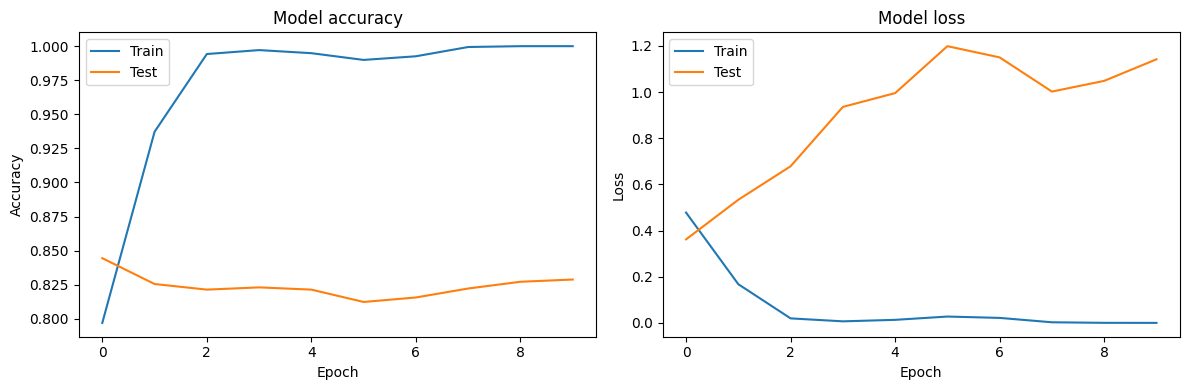

In [85]:
plot_history(IE_history)

82/82 [==============================] - 2s 26ms/step


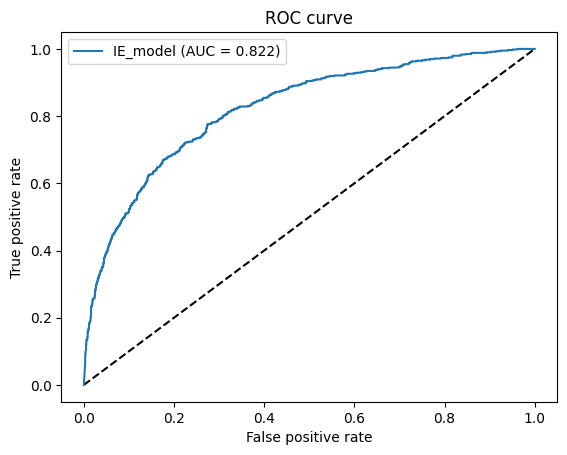

In [86]:
plot_auc(IE_model, 'IE_model', texts_test, labels_test)

In [87]:
IE_model.load_weights("./IE_model.weights.h5")

In [88]:
IE_model.evaluate(texts_test, labels_test)

82/82 [==============================] - 2s 28ms/step - loss: 0.3657 - accuracy: 0.8598 - auc: 0.8740


[0.3657221794128418, 0.8597771525382996, 0.8739641904830933]

 #### Saving

In [89]:
IE_model.save("./IE_model.keras")

### Intuition (0) – Sensing (1)

#### Preparation

In [31]:
texts_train, texts_test, labels_train, labels_test = train_test_split(
    texts, df["sensing"], train_size=0.7, random_state=123
)

#### Training & Testing

In [32]:
embedding_dim = 512

inputs = tf.keras.Input(shape=(max_seq_length,))

embedding = tf.keras.layers.Embedding(
    input_dim=vocab_length, output_dim=embedding_dim, input_length=max_seq_length
)(inputs)

conv1d = tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation="relu")(
    embedding
)

lstm = tf.keras.layers.LSTM(units=256, return_sequences=True)(conv1d)

flatten = tf.keras.layers.Flatten()(lstm)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(flatten)

NS_model = tf.keras.Model(inputs, outputs)

NS_model.compile(
    optimizer="nadam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")],
)

NS_history = NS_model.fit(
    texts_train,
    labels_train,
    validation_split=0.2,
    batch_size=32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            "./NS_model.weights.h5", save_best_only=True, save_weights_only=True
        )
    ],
)

Epoch 1/10
152/152 [==============================] - 40s 205ms/step - loss: 0.3633 - accuracy: 0.8625 - auc: 0.7298 - val_loss: 0.3217 - val_accuracy: 0.8947 - val_auc: 0.8834
Epoch 2/10
152/152 [==============================] - 23s 153ms/step - loss: 0.1073 - accuracy: 0.9629 - auc: 0.9815 - val_loss: 0.4207 - val_accuracy: 0.8683 - val_auc: 0.8335
Epoch 3/10
152/152 [==============================] - 19s 126ms/step - loss: 0.0159 - accuracy: 0.9955 - auc: 0.9996 - val_loss: 0.6188 - val_accuracy: 0.8741 - val_auc: 0.7650
Epoch 4/10
152/152 [==============================] - 18s 118ms/step - loss: 0.0036 - accuracy: 0.9994 - auc: 1.0000 - val_loss: 0.7479 - val_accuracy: 0.8831 - val_auc: 0.7634
Epoch 5/10
152/152 [==============================] - 16s 104ms/step - loss: 3.6972e-04 - accuracy: 0.9998 - auc: 1.0000 - val_loss: 0.8473 - val_accuracy: 0.8790 - val_auc: 0.7451
Epoch 6/10
152/152 [==============================] - 15s 97ms/step - loss: 2.4461e-04 - accuracy: 1.0000 - auc

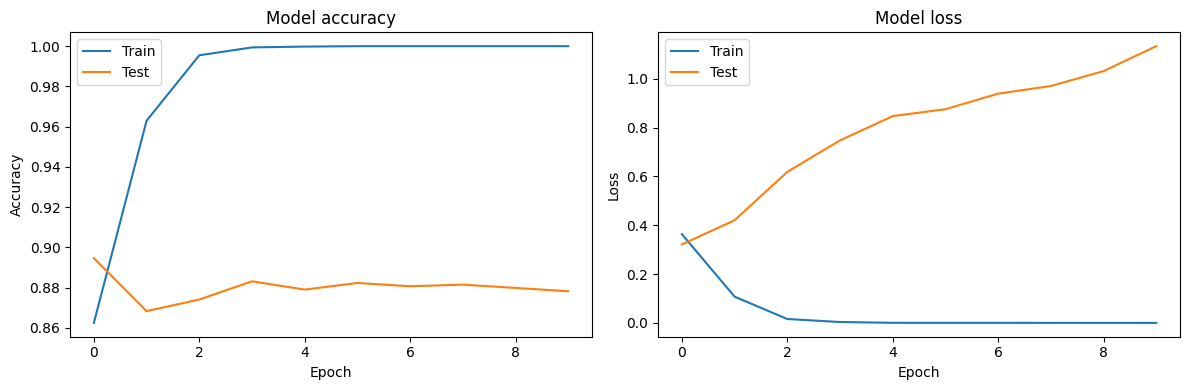

In [33]:
plot_history(NS_history)

82/82 [==============================] - 3s 26ms/step


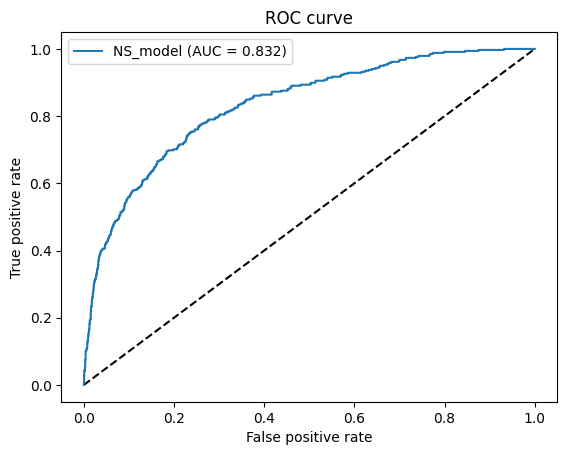

In [34]:
plot_auc(NS_model, 'NS_model', texts_test, labels_test)

In [35]:
NS_model.load_weights("./NS_model.weights.h5")

In [36]:
NS_model.evaluate(texts_test, labels_test)

82/82 [==============================] - 2s 29ms/step - loss: 0.3116 - accuracy: 0.8894 - auc: 0.8629


[0.31158605217933655, 0.8893584609031677, 0.8628564476966858]

#### Saving

In [39]:
NS_model.save("./NS_model.keras")

### Thinking (0) – Feeling (1)

#### Preparation

In [40]:
texts_train, texts_test, labels_train, labels_test = train_test_split(
    texts, df["feeling"], train_size=0.7, random_state=123
)

#### Training & Testing

In [46]:
embedding_dim = 512

inputs = tf.keras.Input(shape=(max_seq_length,))

embedding = tf.keras.layers.Embedding(
    input_dim=vocab_length, output_dim=embedding_dim, input_length=max_seq_length
)(inputs)

conv1d = tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation="relu")(
    embedding
)

lstm = tf.keras.layers.LSTM(units=256, return_sequences=True)(conv1d)

flatten = tf.keras.layers.Flatten()(lstm)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(flatten)

TF_model = tf.keras.Model(inputs, outputs)

TF_model.compile(
    optimizer="nadam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")],
)

TF_history = TF_model.fit(
    texts_train,
    labels_train,
    validation_split=0.2,
    batch_size=32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            "./TF_model.weights.h5", save_best_only=True, save_weights_only=True
        )
    ],
)

Epoch 1/10
152/152 [==============================] - 32s 186ms/step - loss: 0.5017 - accuracy: 0.7400 - auc: 0.8305 - val_loss: 0.3581 - val_accuracy: 0.8444 - val_auc: 0.9230
Epoch 2/10
152/152 [==============================] - 22s 148ms/step - loss: 0.1806 - accuracy: 0.9329 - auc: 0.9798 - val_loss: 0.4540 - val_accuracy: 0.8165 - val_auc: 0.8984
Epoch 3/10
152/152 [==============================] - 20s 132ms/step - loss: 0.0387 - accuracy: 0.9870 - auc: 0.9989 - val_loss: 0.7266 - val_accuracy: 0.8132 - val_auc: 0.8794
Epoch 4/10
152/152 [==============================] - 18s 119ms/step - loss: 0.0097 - accuracy: 0.9973 - auc: 0.9999 - val_loss: 1.2767 - val_accuracy: 0.7852 - val_auc: 0.8639
Epoch 5/10
152/152 [==============================] - 16s 105ms/step - loss: 0.0015 - accuracy: 0.9998 - auc: 1.0000 - val_loss: 1.1025 - val_accuracy: 0.8066 - val_auc: 0.8639
Epoch 6/10
152/152 [==============================] - 15s 97ms/step - loss: 3.6985e-04 - accuracy: 0.9998 - auc: 1.

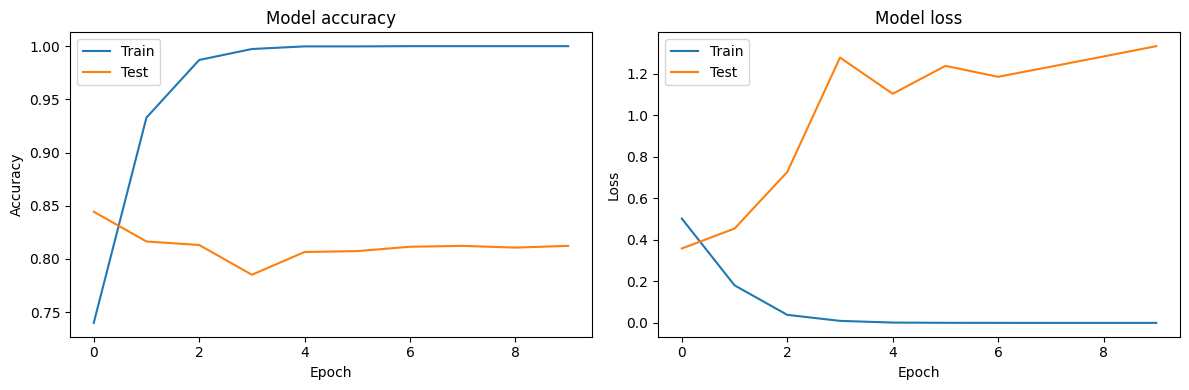

In [47]:
plot_history(TF_history)

82/82 [==============================] - 2s 25ms/step


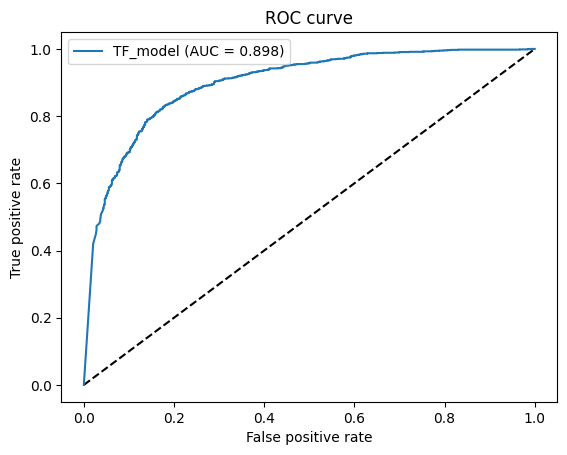

In [48]:
plot_auc(TF_model, 'TF_model', texts_test, labels_test)

In [49]:
TF_model.load_weights("./TF_model.weights.h5")

In [50]:
TF_model.evaluate(texts_test, labels_test)

82/82 [==============================] - 2s 28ms/step - loss: 0.3800 - accuracy: 0.8398 - auc: 0.9149


[0.3799954652786255, 0.839800238609314, 0.9149192571640015]

#### Saving

In [51]:
TF_model.save("./TF_model.keras")

### Judging (0) – Perceiving (1)

#### Preparation

In [52]:
texts_train, texts_test, labels_train, labels_test = train_test_split(
    texts, df["perceiving"], train_size=0.7, random_state=123
)

#### Training & Testing

In [61]:
embedding_dim = 512

inputs = tf.keras.Input(shape=(max_seq_length,))

embedding = tf.keras.layers.Embedding(
    input_dim=vocab_length, output_dim=embedding_dim, input_length=max_seq_length
)(inputs)

conv1d = tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation="relu")(
    embedding
)

lstm = tf.keras.layers.LSTM(units=256, return_sequences=True)(conv1d)

flatten = tf.keras.layers.Flatten()(lstm)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(flatten)

JP_model = tf.keras.Model(inputs, outputs)

JP_model.compile(
    optimizer="nadam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")],
)

JP_history = JP_model.fit(
    texts_train,
    labels_train,
    validation_split=0.2,
    batch_size=32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            "./JP_model.weights.h5", save_best_only=True, save_weights_only=True
        )
    ],
)

Epoch 1/10
152/152 [==============================] - 32s 185ms/step - loss: 0.5926 - accuracy: 0.6803 - auc: 0.7257 - val_loss: 0.4899 - val_accuracy: 0.7695 - val_auc: 0.8444
Epoch 2/10
152/152 [==============================] - 22s 147ms/step - loss: 0.2581 - accuracy: 0.9004 - auc: 0.9577 - val_loss: 0.6873 - val_accuracy: 0.7416 - val_auc: 0.7972
Epoch 3/10
152/152 [==============================] - 20s 130ms/step - loss: 0.0475 - accuracy: 0.9821 - auc: 0.9985 - val_loss: 1.0697 - val_accuracy: 0.7333 - val_auc: 0.7663
Epoch 4/10
152/152 [==============================] - 17s 113ms/step - loss: 0.0125 - accuracy: 0.9979 - auc: 0.9999 - val_loss: 1.2568 - val_accuracy: 0.7399 - val_auc: 0.7743
Epoch 5/10
152/152 [==============================] - 16s 108ms/step - loss: 0.0036 - accuracy: 0.9994 - auc: 1.0000 - val_loss: 1.4679 - val_accuracy: 0.7358 - val_auc: 0.7735
Epoch 6/10
152/152 [==============================] - 15s 97ms/step - loss: 4.9633e-04 - accuracy: 0.9998 - auc: 1.

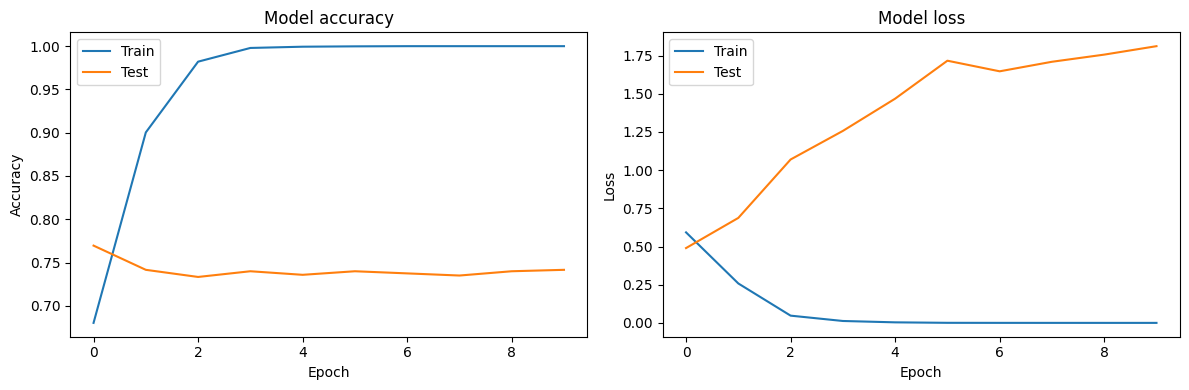

In [62]:
plot_history(JP_history)

82/82 [==============================] - 2s 26ms/step


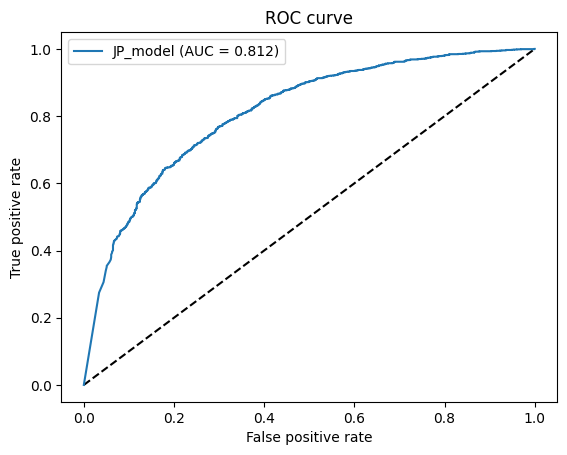

In [63]:
plot_auc(JP_model, 'JP_model', texts_test, labels_test)

In [64]:
JP_model.load_weights("./JP_model.weights.h5")

In [65]:
JP_model.evaluate(texts_test, labels_test)

82/82 [==============================] - 2s 29ms/step - loss: 0.4938 - accuracy: 0.7856 - auc: 0.8482


[0.4938068687915802, 0.7856319546699524, 0.848229706287384]

#### Saving

In [66]:
JP_model.save("./JP_model.keras")

### Trying Models

1. Loading Models & Tokenizer

In [67]:
ie_model = keras.models.load_model("./IE_model.keras")
ns_model = keras.models.load_model("./NS_model.keras")
tf_model = keras.models.load_model("./TF_model.keras")
jp_model = keras.models.load_model("./JP_model.keras")

with open("./tokenizer.json") as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

2. Classification Function

In [68]:
def classify_mbti(tweet):
    # Prepare results variable
    result = ""

    # Preprocess the tweet
    stop_words = stopwords.words("english")
    tweet = tweet.lower()
    tweet = re.sub(r'https?://[^\s<>"]+|www\.[^\s<>"]+', "", tweet)
    tweet = re.sub(r"@[\w]+", "", tweet)
    tweet = re.sub(r":[^:]+:", "", tweet)
    tweet = tweet.split()
    tweet = [word.strip() for word in tweet]
    tweet = [word for word in tweet if word not in stop_words]

    # Tokenize the tweet
    tweet = tokenizer.texts_to_sequences([tweet])

    # Pad the sequence
    tweet = pad_sequences(tweet, maxlen=max_seq_length, padding="post")

    # Make predictions
    predictions = {
        "IE": ie_model.predict(tweet),
        "NS": ns_model.predict(tweet),
        "TF": tf_model.predict(tweet),
        "JP": jp_model.predict(tweet),
    }

    # Classify MBTI type based on predictions
    for model_label, prediction in predictions.items():
        if prediction < 0.5:
            result += model_label[0]
        else:
            result += model_label[1]

    return result

3. Trials

In [70]:
text = "I am an introverted person who enjoys spending time alone. I am also a creative and imaginative person who enjoys writing and painting."
classify_mbti(text)

1/1 [==============================] - 0s 26ms/step


'ISTP'

In [71]:
!jupyter nbconvert --to html PersonAI.ipynb


[NbConvertApp] Converting notebook PersonAI.ipynb to html
[NbConvertApp] Writing 1265101 bytes to PersonAI.html
